Importing necessary libraries:

In [1]:
import numpy as np
import pandas as pd

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

In [3]:
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU

Using TensorFlow backend.


In [4]:
pwd

'/Users/lilipiesanen/SureStart FutureMakers Program + Projects'

Loading the Dataset:

In [5]:
df = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


Data Visualization and Preprocessing:

In [6]:
df.isna().sum() #Checking for NaN values

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [7]:
del df['article_link'] #Deleting this column bc it has no use

In [8]:
df.head() #Displaying the first five rows in dataset

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


/Users/lilipiesanen/opt/anaconda3/envs/SureStart/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='is_sarcastic', ylabel='count'>

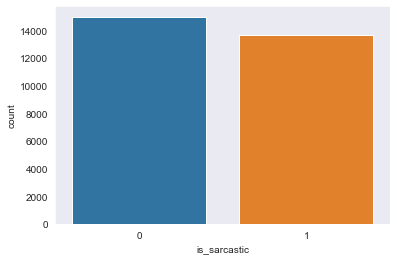

In [9]:
sns.set_style("dark") #Setting sytle to dark mode
sns.countplot(df.is_sarcastic) #Displaying countplot of dataset using seaborn

Eliminating Stopwords and Doing Basic Data Cleaning

In [10]:
import nltk
#nltk.download('stopwords')

In [11]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [12]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing URLs
def remove_between_square_brackets(text):
    return re.sub(r'http\S+','', text)

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())         
    return " ".join(final_text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

#Apply function on review column
df['headline']=df['headline'].apply(denoise_text)

Introduction to Word Embedding and Word2Vec:

Word embedding is one of the most popular representation of document vocabulary. It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc. What are word embeddings exactly? Loosely speaking, they are vector representations of a particular word. Having said this, what follows is how do we generate them? More importantly, how do they capture the context? Word2Vec is one of the most popular technique to learn word embeddings using shallow neural network. It was developed by Tomas Mikolov in 2013 at Google.

Converting Text to Format Acceptable

In [13]:
words = []
for i in df.headline.values:
    words.append(i.split())
words[:5]

[['thirtysomething',
  'scientists',
  'unveil',
  'doomsday',
  'clock',
  'hair',
  'loss'],
 ['dem',
  'rep.',
  'totally',
  'nails',
  'congress',
  'falling',
  'short',
  'gender,',
  'racial',
  'equality'],
 ['eat', 'veggies:', '9', 'deliciously', 'different', 'recipes'],
 ['inclement', 'weather', 'prevents', 'liar', 'getting', 'work'],
 ['mother',
  'comes',
  'pretty',
  'close',
  'using',
  'word',
  "'streaming'",
  'correctly']]

In [15]:
import gensim
EMBEDDING_DIM = 200 #Dimension of vectors we want to generate

#Creating Word Vectors by Word2Vec Method
w2v_model = gensim.models.Word2Vec(sentences = words , vector_size = EMBEDDING_DIM , window = 5 , min_count = 1)

In [17]:
#vocab size
len(w2v_model.wv)
#^We have now represented each of 38071 words by a 100 dimension vector

38071

In [18]:
tokenizer = text.Tokenizer(num_words=350000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = sequence.pad_sequences(tokenized_train, maxlen = 20)

In [19]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [20]:
#Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    #total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    #define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    #step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [39]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model.wv, tokenizer.word_index)

Training Word2Vec Model

In [41]:
#Defining Neural Network
model = Sequential()

#Non-trainable embedding layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=20, trainable=True))

#LSTM
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
model.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

In [42]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 200)           7614400   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20, 256)           336896    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                55488     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 8,006,849
Trainable params: 8,006,849
Non-trainable params: 0
_________________________________________________________________


In [45]:
x_train, x_test, y_train, y_test = train_test_split(x, df.is_sarcastic , test_size = 0.3 , random_state = 0) 

In [46]:
history = model.fit(x_train, y_train, batch_size = 128 , validation_data = (x_test,y_test) , epochs = 3)

/Users/lilipiesanen/opt/anaconda3/envs/SureStart/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20033 samples, validate on 8586 samples
Epoch 1/3
20033/20033 [==============================] - 95s 5ms/step - loss: 0.5220 - acc: 0.7262 - val_loss: 0.4222 - val_acc: 0.8074
Epoch 2/3
20033/20033 [==============================] - 84s 4ms/step - loss: 0.1510 - acc: 0.9427 - val_loss: 0.4999 - val_acc: 0.7923
Epoch 3/3
20033/20033 [==============================] - 87s 4ms/step - loss: 0.0349 - acc: 0.9885 - val_loss: 0.7341 - val_acc: 0.7948


In [47]:
print("Accuracy of the model on Training Data is -", model.evaluate(x_train, y_train) [1]*100)
print("Accuracy of the model of Testing Data is -", model.evaluate(x_test, y_test) [1]*100)

20033/20033 [==============================] - 26s 1ms/step
Accuracy of the model on Training Data is - 99.85024929046631
8586/8586 [==============================] - 11s 1ms/step
Accuracy of the model of Testing Data is - 79.47822213172913


Analysis After Training Word2Vec Model

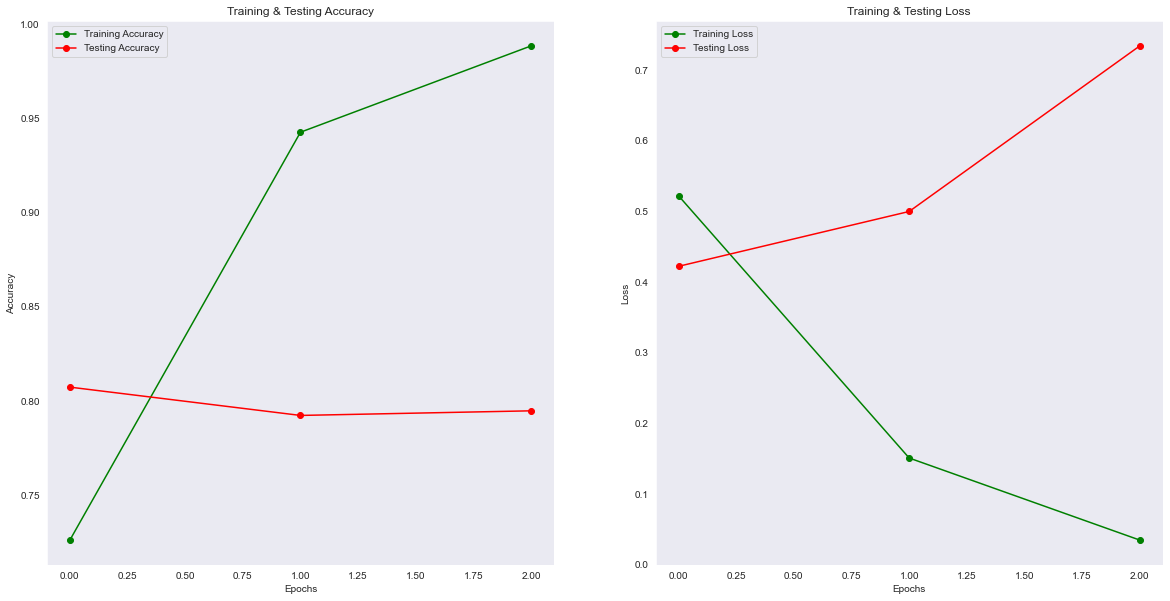

In [48]:
epochs = [i for i in range(3)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()


In [49]:
#^Seems like the model is overfitting and not performing well on the test data but thats ok!